#Table of Contents
* [1. Motivation](#1.-Motivation)
* ...

# 1. Motivation

(Show the original slides here by Hassen, ie the dashboard plots)

Can we conclude that the upgrade made an improvement?
Can we say anything more?


# 2. (Make sure the relevant monitoring data is stored and kept)

We started with average file sizes and average transfer times, then Hassen had to go back to find the individual transfer records

In general remember that
- by merging and aggregating data and keeping only averages and sums, you are losing interesting information
- the interesting information and the useful results are often found by separating data categories instead!

You clearly cannot keep all the data for all individual "events", however
- try to keep granular information as much as possible (and all relevant variables, maybe group them by relevant variables?)
- why not keep a fraction of individual events too? (HEP trigger downscaling...) 


# 3. Create and load the input raw data (JSON files)

The original data files looked like JSON but did not respect the JSON syntax:
- they used single quotes, but JSON only supports double quotes
- they included a JSON array [{..},{..},{..}] but this object was not named
- they included (at the end of every bulk retrieval from the DB?) some [] strings, which broke the JSON syntax
- they used "None" for missing values, but the correct JSON syntax is "null" (without quotes)
Debugging the issues above was not trivial (and got much easier when I replaced the json library by the simplejson library). 

On top of this, the original files had a few other issues:
- they were very long (3GB for CERN and almost 2GB for RAL data), probably too large to fit in memory in my ipython server
- they included one single line with 2G to 3G characters (and to make shorter files I had to use O/S tools like sed that choke on such long lines)

To work around these issues, I first split the files into several lines using fmt, then applied sed and other tools to fix the JSON issues and also to produce shorter versions with only 1M lines. Note also that analyses are iterative:
- you can start to work with a small file to get a first understanding
- you can then go back and retrieve larger statistics from the database, selecting only the interesting subsets of data...

The original files corresponded to one month of data. This notebook uses these shorter 1M-transfer files, of roughly 300MB, so around 3 days of FTS data for CERN and a few more days for RAL.

In [2]:
# This is the script used to produce the shorter version of the cern.txt file and to prepare JSON compliant files
print open('jsonize_all.sh').read()

#!/bin/sh
echo "You must comment out this line!"; exit 1

cd /home/avalassi/WA/hassen/JSON
for file in cern ral ; do
  # Split the file into separate lines (otherwise sed chokes!)
  \rm -f ${file}_fmt.txt
  time fmt -s -w1 ../RAW/$file.txt > ${file}_fmt.txt # approx 120s each file
  # Then convert to JSON format
  \rm -f $file.json
  echo '{"transfers":' > $file.json
  time cat ${file}_fmt.txt | sed -e "s/}\]\[{/},\n{/g" -e "s/\]\[//g" -e "s/\[{/\[\n{/" -e "s/}\]/}\n\]/" -e 's/'\''/"/g' -e 's/None,/null,/' >> $file.json # approx 180s each file
  echo "}" >> $file.json
  # Create smaller 300MB files with only 1M transfers i.e. 16M+2 lines
  # (one transfer record is 16 lines, also include the first 2 header lines)
  \rm -f ${file}1M.json
  time head -16000001 $file.json > ${file}1M.json # first 16M+1
  time awk 'NR == 16000002{print; exit}' $file.json | sed 's/,$//' >> ${file}1M.json # delete trailing comma on 16M+2th line
  echo "]" >> ${file}1M.json
  echo "}" >> ${file}1M.json
done



In [2]:
# Use the simplejson library because it allows much better debugging of issues in your JSON file!
# See http://stackoverflow.com/questions/14899506/displaying-better-error-message-than-no-json-object-could-be-decoded
import simplejson

# Load 1M rows of CERN transfer data into a python dictionary - SLOW!
cdata = simplejson.load(open('cern1M.json'))

# Load 1M rows of CERN transfer data into a python dictionary - SLOW!
rdata = simplejson.load(open('ral1M.json'))

# 4. Load the data into Python "ntuples" (pandas DataFrames)

This analysis could clearly be done with ROOT too (and the setup of this ipython server includes ROOT). But initially I will use Python-only tools, in particular I will load data into pandas DataFrames.

In [3]:
# Extract transfers (the original JSON arrays) as python lists of dictionaries - this is fast
crows=cdata['transfers']
rrows=rdata['transfers']

In [4]:
print "CERN"
print len(crows)
print crows[0]
print "RAL"
print len(rrows)
print rrows[0]

CERN
1000000
{'timestamp_tr_comp': '2015-04-06T00:01:40', 'dst_hostname': 'golias100.farm.particle.cz', 'timestamp_tr_st': '2015-04-06T00:01:37', 'transfer_time': 3, 'f_size': 235564162, 'src_hostname': 'eosatlassftp.cern.ch', 'endpnt': 'fts3.cern.ch', 't_channel': 'gsiftp://eosatlassftp.cern.ch__srm://golias100.farm.particle.cz'}
RAL
1000000
{'timestamp_tr_comp': '2015-04-17T00:00:50', 'dst_hostname': 'cmseos.fnal.gov', 'timestamp_tr_st': '2015-04-17T00:00:46', 'transfer_time': 4, 'f_size': 45403, 'src_hostname': 'dcache-se-cms.desy.de', 'endpnt': 'lcgfts3.gridpp.rl.ac.uk', 't_channel': 'srm://dcache-se-cms.desy.de__srm://cmseos.fnal.gov'}


In [5]:
# Check that pandas exists
import pandas

In [6]:
# Load each list of 1M dictionary into a pandas DataFrame ("ntuple") - this is also fast
from pandas import DataFrame
cdf = DataFrame(crows)
rdf = DataFrame(rrows)

In [7]:
# The imported columns have names that are difficult to digest in Latex for matplotlib plots (u'xxx'...)
print cdf.columns
print rdf.columns

Index([u'dst_hostname', u'endpnt', u'f_size', u'src_hostname', u't_channel', u'timestamp_tr_comp', u'timestamp_tr_st', u'transfer_time'], dtype='object')
Index([u'dst_hostname', u'endpnt', u'f_size', u'src_hostname', u't_channel', u'timestamp_tr_comp', u'timestamp_tr_st', u'transfer_time'], dtype='object')


In [8]:
# Change column names (and make them more user friendly too!)
# See http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
cdf.columns = ['dst', 'endpnt', 'fsize', 'src', 'chan', 'since', 'until', 'ttime']
rdf.columns = ['dst', 'endpnt', 'fsize', 'src', 'chan', 'since', 'until', 'ttime']
print cdf.columns
print rdf.columns

Index([u'dst', u'endpnt', u'fsize', u'src', u'chan', u'since', u'until', u'ttime'], dtype='object')
Index([u'dst', u'endpnt', u'fsize', u'src', u'chan', u'since', u'until', u'ttime'], dtype='object')


# 5. Data analysis (data selection, histogram plots, scatter plots...)

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

## 5.1 Full 1M samples - file size and transfer time

### File size

(array([  9.75168000e+05,   2.42350000e+04,   5.00000000e+02,
          3.90000000e+01,   2.40000000e+01,   1.60000000e+01,
          1.10000000e+01,   1.00000000e+00,   0.00000000e+00,
          6.00000000e+00]),
 array([  6.90000000e+01,   3.90193464e+09,   7.80386921e+09,
          1.17058038e+10,   1.56077384e+10,   1.95096729e+10,
          2.34116075e+10,   2.73135421e+10,   3.12154766e+10,
          3.51174112e+10,   3.90193458e+10]),
 <a list of 10 Patch objects>)

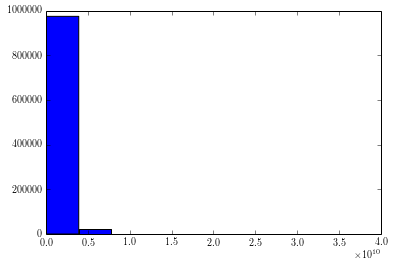

In [10]:
# 1D histos (filesize) - CERN
plt.hist(cdf.fsize)
# Alternative from Domenico: cdf.fsize.hist()

(array([  9.98079000e+05,   1.44900000e+03,   2.41000000e+02,
          1.90000000e+02,   3.90000000e+01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  4.50000000e+01,   6.62628085e+09,   1.32525616e+10,
          1.98788425e+10,   2.65051233e+10,   3.31314041e+10,
          3.97576849e+10,   4.63839657e+10,   5.30102465e+10,
          5.96365273e+10,   6.62628081e+10]),
 <a list of 10 Patch objects>)

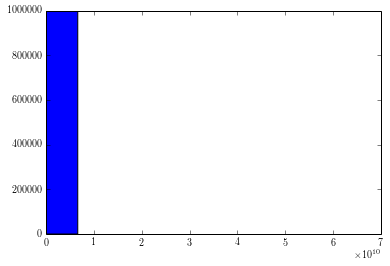

In [11]:
# 1D histos (filesize) - RAL
plt.hist(rdf.fsize)

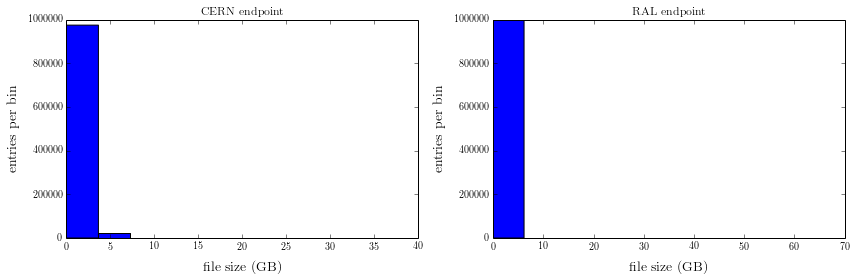

In [12]:
# Basic visual formatting

# Two plots next to each other with titles
fig = plt.figure(figsize=(12,4))
cax = fig.add_subplot(121)
rax = fig.add_subplot(122)
cax.set_title('CERN endpoint')
rax.set_title('RAL endpoint')

# Add x and y labels - what are we plotting?
cax.set_xlabel('file size (GB)', labelpad=8, fontsize=14)
cax.set_ylabel('entries per bin', labelpad=8, fontsize=14)
rax.set_xlabel('file size (GB)', labelpad=8, fontsize=14)
rax.set_ylabel('entries per bin', labelpad=8, fontsize=14)

# Repeat the same plots as above, for the moment
ch = cax.hist(cdf.fsize/1024**3)
rh = rax.hist(rdf.fsize/1024**3)

# When you add labels and several plots per figure, use tight_layout to improve the spacing
# This must be called at the end...
plt.tight_layout()

In [13]:
# Save our previous visual formatting for the future
def twoHistos(xlabel='file size (GB)'):
    # Two plots next to each other with titles
    fig = plt.figure(figsize=(12,4))
    cax = fig.add_subplot(121)
    rax = fig.add_subplot(122)
    cax.set_title('CERN endpoint')
    rax.set_title('RAL endpoint')
    # Add x and y labels - what are we plotting?
    cax.set_xlabel(xlabel, labelpad=8, fontsize=14)
    cax.set_ylabel('entries per bin', labelpad=8, fontsize=14)
    rax.set_xlabel(xlabel, labelpad=8, fontsize=14)
    rax.set_ylabel('entries per bin', labelpad=8, fontsize=14)
    return cax, rax

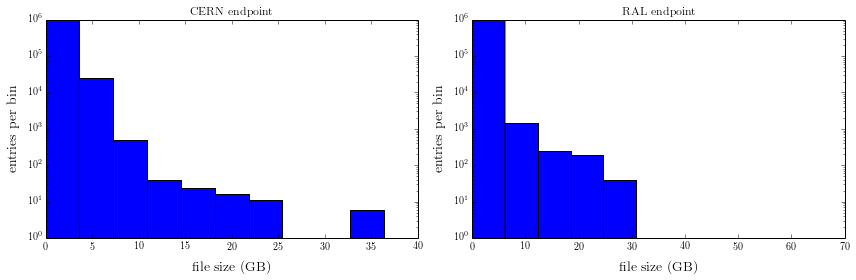

In [14]:
# Basic visual formatting
cax, rax = twoHistos()

# Zoom using log scales: use log=True instead of set_yscale("log")
# See http://stackoverflow.com/a/22945052
# See http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist
ch = cax.hist(cdf.fsize/1024**3, log=True)
rh = rax.hist(rdf.fsize/1024**3, log=True)
plt.tight_layout()

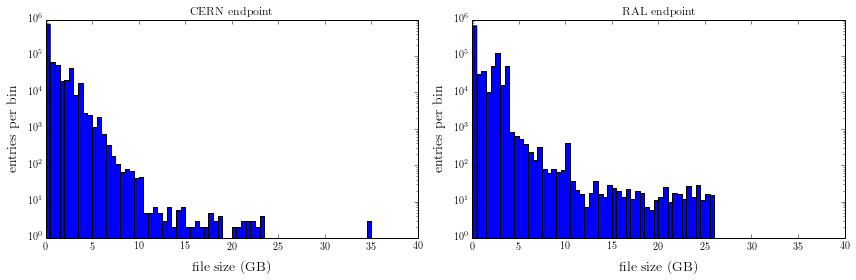

In [15]:
# Basic visual formatting
cax, rax = twoHistos()

# Choose the same x-range for both plots
xmin = fsizegbmin = 0. 
xmax = fsizegbmax = 40.
cax.set_xlim([xmin,xmax])
rax.set_xlim([xmin,xmax])

# Choose an appropriate binning (80 is one bin per 500MB)
nbin = 80
binw = (xmax-xmin)/nbin
bins = np.arange(xmin,xmax+binw,binw)

# Improved binning
ch = cax.hist(cdf.fsize/1024**3, log=True, bins=bins)
rh = rax.hist(rdf.fsize/1024**3, log=True, bins=bins)
plt.tight_layout()

### Transfer time

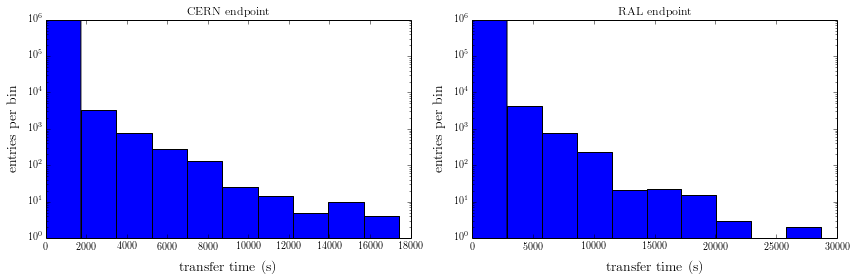

In [16]:
# Basic visual formatting
cax, rax = twoHistos('transfer time (s)')

# First look at transfer times, using log scales
ch = cax.hist(cdf.ttime, log=True)
rh = rax.hist(rdf.ttime, log=True)
plt.tight_layout()

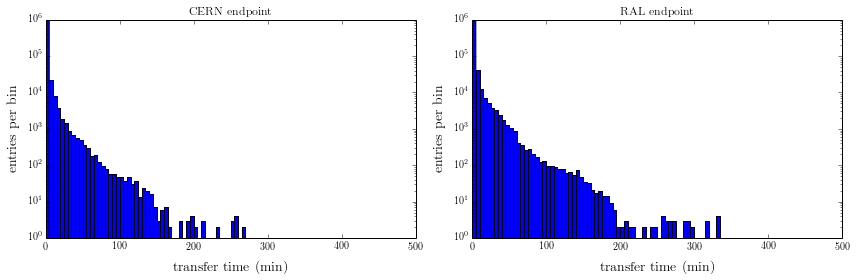

In [17]:
# Basic visual formatting
cax, rax = twoHistos('transfer time (min)')

# Choose the same x-range for both plots
xmin = ttime60min = 0. 
xmax = ttime60max = 500. # 500 minutes i.e. 30000s
cax.set_xlim([xmin,xmax])
rax.set_xlim([xmin,xmax])

# Choose an appropriate binning (100 is one bin per 5 minutes)
nbin = 100
binw = (xmax-xmin)/nbin
bins = np.arange(xmin,xmax+binw,binw)

# Improved binning
ch = cax.hist(cdf.ttime/60, log=True, bins=bins)
rh = rax.hist(rdf.ttime/60, log=True, bins=bins)
plt.tight_layout()

## 5.2 Identifying some first issues - this leads to the need to select subsamples!

### Throughput (file size / transfer time) - why can I not plot this?

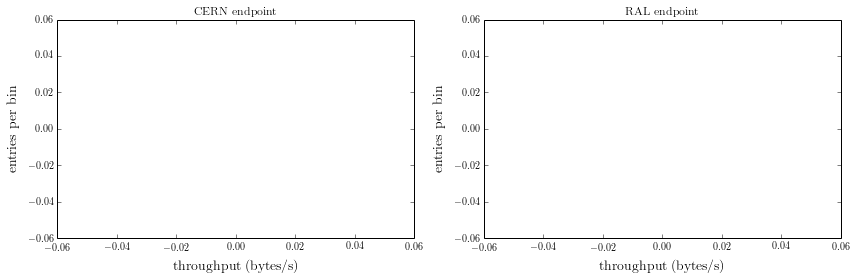

In [18]:
# Basic visual formatting
cax, rax = twoHistos('throughput (bytes/s)')

# First look at througput (linear, because log gives an error)
ch = cax.hist((cdf.fsize/cdf.ttime))
rh = rax.hist((rdf.fsize/rdf.ttime))
plt.tight_layout()

# ...??? why are these plots empty?!...

In [19]:
# Do I have a problem in my matplotlib syntax?
# Try to see if "cdf.fsize/cdf.ttime" is a valid syntax
print (cdf.fsize/cdf.ttime) 

# GOT IT! The syntax is right, but there is something wrong in the values!
# Why is throughput "infinite"? Probably transfer time is 0...

0         7.852139e+07
1         5.242880e+05
2         1.045278e+06
3         5.880508e+07
4         5.706266e+07
5         1.490833e+02
6         2.557863e+06
7         1.754378e+08
8         1.284158e+07
9         5.315627e+07
10        1.022271e+06
11        2.621440e+05
12                 inf
13        4.415789e+07
14        1.952757e+05
15        9.406402e+07
16        3.870457e+06
17        3.504767e+07
18        3.156950e+06
19        9.351600e+04
20        6.067812e+07
21        5.234926e+07
22        3.547582e+07
23        1.998254e+06
24        8.698341e+06
25        4.962584e+07
26        1.544671e+07
27        4.821936e+07
28        2.598467e+07
29        3.150275e+04
              ...     
999970    2.409611e+06
999971    9.181803e+06
999972    3.993152e+05
999973    9.243645e+05
999974    3.846593e+07
999975    1.150918e+07
999976    2.346387e+06
999977    1.616930e+08
999978    2.053375e+05
999979    3.905796e+06
999980    6.081007e+06
999981    1.542530e+05
999982    4

In [20]:
# Show only the range where we found some problems
print "THROUGHPUT\n", (cdf.fsize/cdf.ttime)[10:20]
print "FILE SIZE\n", (cdf.fsize)[10:20]
print "TRANSFER TIME\n", (cdf.ttime)[10:20]

THROUGHPUT
10    1.022271e+06
11    2.621440e+05
12             inf
13    4.415789e+07
14    1.952757e+05
15    9.406402e+07
16    3.870457e+06
17    3.504767e+07
18    3.156950e+06
19    9.351600e+04
dtype: float64
FILE SIZE
10       1022271
11       1048576
12       1048576
13    2163736757
14       2343308
15    1599088376
16     599920759
17     105143018
18      82080698
19        374064
Name: fsize, dtype: int64
TRANSFER TIME
10      1
11      4
12      0
13     49
14     12
15     17
16    155
17      3
18     26
19      4
Name: ttime, dtype: int64


### Selecting subsamples - use the DataFrame.query function

In [21]:
# How many events are there with time equal 0, and what are they?!
print "#transfers at CERN (TOTAL)  :", len(cdf)
print "#transfers at CERN (size>0) :", len(cdf.query('fsize>0'))
print "#transfers at CERN (time>0) :", len(cdf.query('ttime>0'))
###print "#transfers at CERN (time>0) :", len(cdf[cdf.ttime>0]) # Alternative to query
print "#transfers at CERN (time==0):", len(cdf.query('ttime==0'))
print "#transfers at RAL  (TOTAL)  :", len(rdf)
print "#transfers at RAL  (size>0) :", len(rdf.query('fsize>0'))
print "#transfers at RAL  (time>0) :", len(rdf.query('ttime>0'))
print "#transfers at RAL  (time==0):", len(rdf.query('ttime==0'))

#transfers at CERN (TOTAL)  : 1000000
#transfers at CERN (size>0) : 1000000
#transfers at CERN (time>0) : 957494
#transfers at CERN (time==0): 42506
#transfers at RAL  (TOTAL)  : 1000000
#transfers at RAL  (size>0) : 1000000
#transfers at RAL  (time>0) : 888758
#transfers at RAL  (time==0): 111242


In [22]:
# Create new DataFrame's including only these "bad" records with ttime>0
cdf0 = cdf.query('ttime==0')
rdf0 = rdf.query('ttime==0')

In [23]:
# Show only (some of) the records where transfer time is 0
print "THROUGHPUT\n", (cdf0.fsize/cdf0.ttime)[0:10]
print "FILE SIZE\n", (cdf0.fsize)[0:10]
print "TRANSFER TIME\n", (cdf0.ttime)[0:10]

# There are records with transfer time 0 and large file sizes 
# Some of these may be very fast transfers of small files,
# but probably many of these are failed transfers
# We should exclude them from our analysis!

THROUGHPUT
12     inf
35     inf
56     inf
80     inf
97     inf
110    inf
116    inf
166    inf
168    inf
195    inf
dtype: float64
FILE SIZE
12        1048576
35         207269
56        1048576
80       10614275
97         223774
110    2649616278
116       7116336
166        897593
168        934949
195        994379
Name: fsize, dtype: int64
TRANSFER TIME
12     0
35     0
56     0
80     0
97     0
110    0
116    0
166    0
168    0
195    0
Name: ttime, dtype: int64


## 5.3 Subsamples "DF1" - only with transfer time > 0 (960k CERN, 890k RAL)

In [24]:
# Create new DataFrame's including only these "good" records with ttime>0
cdf1 = cdf.query('ttime>0')
rdf1 = rdf.query('ttime>0')

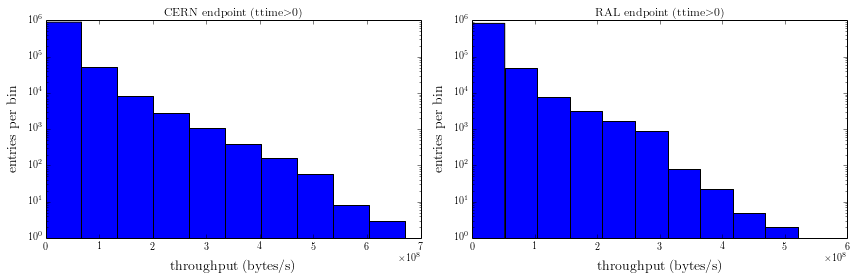

In [25]:
# Basic visual formatting
cax, rax = twoHistos('throughput (bytes/s)')

# Display cuts - use Latex formats in the strings (need to quote ">" within "$")
cax.set_title('CERN endpoint (ttime$>$0)')
rax.set_title('RAL endpoint (ttime$>$0)')
    
# First look at throughput on DF1 samples
ch = cax.hist((cdf1.fsize/cdf1.ttime), log=True)
rh = rax.hist((rdf1.fsize/rdf1.ttime), log=True)
plt.tight_layout()

# Work in progress below

In [26]:
# Cross-check Hassen's initial categories (0-1, 1-2 and >2GB)
print "#transfers at CERN (size<1)  :", len(cdf.query('fsize<1024**3'))
print "#transfers at CERN (1<size<2):", len(cdf.query('1024**3<fsize<2*1024**3'))
print "#transfers at CERN (2<size)  :", len(cdf.query('2*1024**3<fsize'))
print "#transfers at RAL  (size<1)  :", len(rdf.query('fsize<1024**3'))
print "#transfers at RAL  (1<size<2):", len(rdf.query('1024**3<fsize<2*1024**3'))
print "#transfers at RAL  (2<size)  :", len(rdf.query('2*1024**3<fsize'))

#transfers at CERN (size<1)  : 818506
#transfers at CERN (1<size<2): 75495
#transfers at CERN (2<size)  : 105999
#transfers at RAL  (size<1)  : 707220
#transfers at RAL  (1<size<2): 48037
#transfers at RAL  (2<size)  : 244743


In [27]:
# Do we need the  endpoint column? NO, they all have the same endpoint...
###print cdf[0:1]
###print rdf[0:1]
print "#transfers at CERN (endpoint=CERN):", len(cdf.query('endpnt=="fts3.cern.ch"'))
print "#transfers at CERN (endpoint=RAL) :", len(rdf.query('endpnt=="lcgfts3.gridpp.rl.ac.uk"'))

#transfers at CERN (endpoint=CERN): 1000000
#transfers at CERN (endpoint=RAL) : 1000000


In [28]:
# Do we need the channel column? 
# YES because the protocol (srm, gsiftp...) is only defined in the channel
# Probably you can remove the src and dest instead (as they can be parsed from the channel)
###cdf[0:10] # Better DataFrame rendering that with print (but only one at a time...)
rdf[0:10] # Better DataFrame rendering that with print (but only one at a time...)

dst                   endpnt       fsize  \
0       cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk       45403   
1       cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk      772404   
2    srm-eoscms.cern.ch  lcgfts3.gridpp.rl.ac.uk      189949   
3  cmssrm-kit.gridka.de  lcgfts3.gridpp.rl.ac.uk  2684354560   
4         srmcms.pic.es  lcgfts3.gridpp.rl.ac.uk  2749370917   
5       cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk     5739064   
6    srm-eoscms.cern.ch  lcgfts3.gridpp.rl.ac.uk      208155   
7       cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk       67093   
8       cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk       66315   
9         srm01.ifca.es  lcgfts3.gridpp.rl.ac.uk        4273   

                     src                                               chan  \
0  dcache-se-cms.desy.de  srm://dcache-se-cms.desy.de__srm://cmseos.fnal...   
1  t2-srm-02.lnl.infn.it  srm://t2-srm-02.lnl.infn.it__srm://cmseos.fnal...   
2        sbgse1.in2p3.fr    srm://sbgse1.in2p3.fr__srm://srm-eoscms.cern.ch   
3      eoscmsftp.cern.ch  gsiftp://eoscmsftp.cern.ch__srm://cmssrm-kit.g...   
4         ccsrm.in2p3.fr          srm://ccsrm.in2p3.fr__srm://srmcms.pic.es   
5       dcache07.unl.edu      srm://dcache07.unl.edu__srm://cmseos.fnal.gov   
6        sbgse1.in2p3.fr    srm://sbgse1.in2p3.fr__srm://srm-eoscms.cern.ch   
7       ccsrmt2.in2p3.fr      srm://ccsrmt2.in2p3.fr__srm://cmseos.fnal.gov   
8  dcache-se-cms.desy.de  srm://dcache-se-cms.desy.de__srm://cmseos.fnal...   
9        cmseos.fnal.gov         srm://cmseos.fnal.gov__srm://srm01.ifca.es   

                 since                until  ttime  
0  2015-04-17T00:00:50  2015-04-17T00:00:46      4  
1  2015-04-17T00:01:18  2015-04-17T00:01:11      7  
2  2015-04-17T00:02:48  2015-04-17T00:02:47      1  
3  2015-04-17T00:03:04  2015-04-17T00:02:21     43  
4  2015-04-17T00:03:35  2015-04-17T00:02:03     92  
5                 None  2015-04-17T00:03:50      0  
6  2015-04-17T00:04:58  2015-04-17T00:04:56      2  
7  2015-04-17T00:07:11  2015-04-17T00:07:08      3  
8  2015-04-17T00:07:21  2015-04-17T00:07:18      3  
9                 None  2015-04-27T23:50:55      0

In [29]:
# Why is the channel column truncated? This is only the rendering!
print rdf[0:1] # Why is the .gov suffix not there? Probably a DataFrame rendering/printing effect...
print rdf.chan[1] # Does print the .gov suffix
print rdf.chan[1]=="srm://t2-srm-02.lnl.infn.it__srm://cmseos.fnal.gov" # True, the .gov suffix IS there...

               dst                   endpnt  fsize                    src  \
0  cmseos.fnal.gov  lcgfts3.gridpp.rl.ac.uk  45403  dcache-se-cms.desy.de   

                                                chan                since  \
0  srm://dcache-se-cms.desy.de__srm://cmseos.fnal...  2015-04-17T00:00:50   

                 until  ttime  
0  2015-04-17T00:00:46      4  
srm://t2-srm-02.lnl.infn.it__srm://cmseos.fnal.gov
True


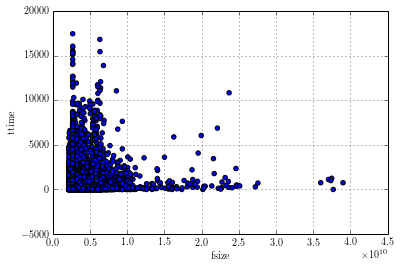

In [30]:
# First look at a scatter plot for CERN
# Ignore file sizes less than 2GB to speed this up (this was also the point of Hassen's first study)
cdf.query('fsize>2*1024**3').plot(kind='scatter', x='fsize', y='ttime');

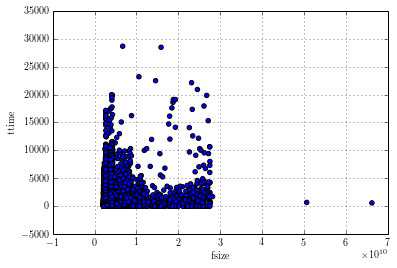

In [31]:
# First look at a scatter plot for RAL
# Ignore file sizes less than 2GB to speed this up (this was also the point of Hassen's first study)
rdf.query('fsize>2*1024**3').plot(kind='scatter', x='fsize', y='ttime');

KeyError: 'fsize/1024**3'

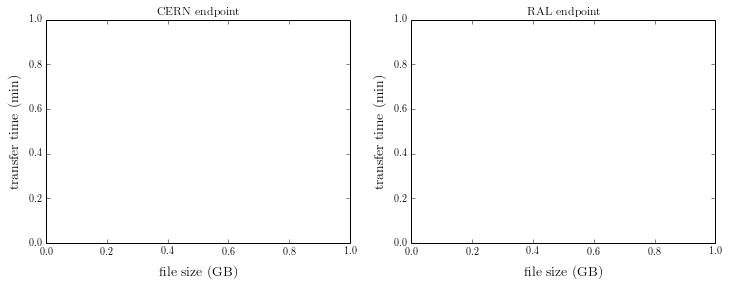

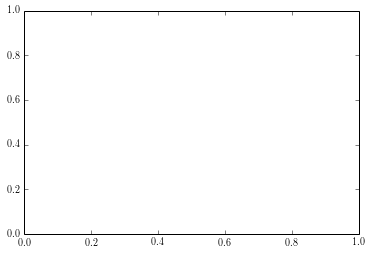

In [32]:
# Two plots next to each other with titles
fig = plt.figure(figsize=(12,4))
cax = fig.add_subplot(121)
rax = fig.add_subplot(122)
cax.set_title('CERN endpoint')
rax.set_title('RAL endpoint')

# Add x and y labels - what are we plotting?
cax.set_xlabel('file size (GB)', labelpad=8, fontsize=14)
cax.set_ylabel('transfer time (min)', labelpad=8, fontsize=14)
rax.set_xlabel('file size (GB)', labelpad=8, fontsize=14)
rax.set_ylabel('transfer time (min)', labelpad=8, fontsize=14)

# 2D scatter plot (file size vs transfer time) with cuts
cs = cdf.plot(kind='scatter', x='fsize/1024**3', y='ttime/60');

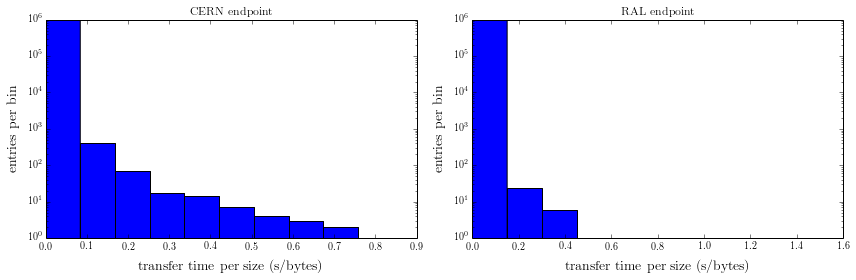

In [33]:
# Basic visual formatting
cax, rax = twoHistos('transfer time per size (s/bytes)')

# First look at inverse througput
# See http://stackoverflow.com/a/17813277
ch = cax.hist((cdf.ttime/cdf.fsize),log=True)
rh = rax.hist((rdf.ttime/rdf.fsize),log=True)
plt.tight_layout()

In [34]:
# Create new DataFrame's including only these "good" records with ttime>0
cdf0 = cdf.query('ttime>0')
rdf0 = rdf.query('ttime>0')

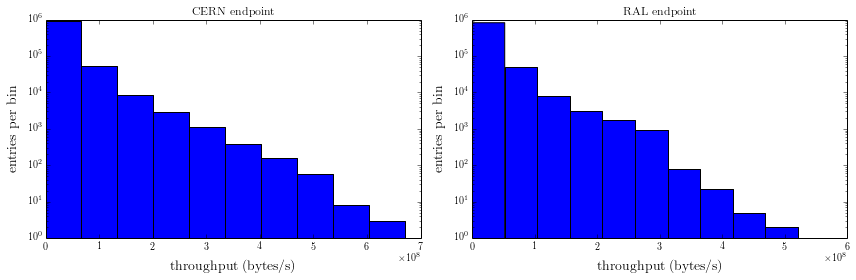

In [35]:
# Basic visual formatting
cax, rax = twoHistos('throughput (bytes/s)')

# First look at througput, using only records with time>0!
ch = cax.hist((cdf0.fsize/cdf0.ttime),log=True)
rh = rax.hist((rdf0.fsize/rdf0.ttime),log=True)
plt.tight_layout()

In [36]:
# Concentrate on Hassen's initial data set with file sizes > 2 GB now
# Create new DataFrame's including only "good" records and only those with fsize>2GB
cdf2 = cdf0.query('fsize>2*1024**3')
rdf2 = rdf0.query('fsize>2*1024**3')
print "#transfers at CERN (time>0):", len(cdf.query('ttime>0')), len(cdf0)
print "#transfers at CERN (& >2GB):", len(cdf.query('(ttime>0) & (fsize>2*1024**3)')), len(cdf2)
print "#transfers at RAL  (time>0):", len(rdf.query('ttime>0')), len(rdf0)
print "#transfers at RAL  (& >2GB):", len(rdf.query('(ttime>0) & (fsize>2*1024**3)')), len(rdf2)

#transfers at CERN (time>0): 957494 957494
#transfers at CERN (& >2GB): 101572 101572
#transfers at RAL  (time>0): 888758 888758
#transfers at RAL  (& >2GB): 221158 221158


13        4.415789e+07
39        1.290863e+08
40        6.803940e+07
42        1.056833e+07
49        4.542041e+07
54        2.808651e+07
73        8.618632e+07
101       2.910146e+07
102       1.010609e+08
124       1.078054e+07
137       1.377009e+08
152       4.431143e+07
157       2.532410e+07
169       3.983995e+07
170       2.700975e+07
175       3.027176e+07
209       9.275207e+06
220       5.700477e+05
231       5.283797e+06
234       3.569338e+07
235       9.381420e+06
241       8.388608e+07
259       2.177092e+06
260       6.723535e+06
265       6.649460e+07
273       3.383715e+07
276       2.064888e+07
296       4.459177e+07
320       8.659208e+07
323       1.348922e+07
              ...     
999777    5.569999e+07
999783    3.873684e+07
999785    2.646051e+07
999786    3.441480e+07
999789    6.632736e+07
999794    8.001635e+07
999802    1.072185e+08
999803    6.983250e+06
999821    6.494269e+06
999824    3.994575e+06
999826    4.422330e+06
999830    4.984028e+07
999838    7

KeyError: 0

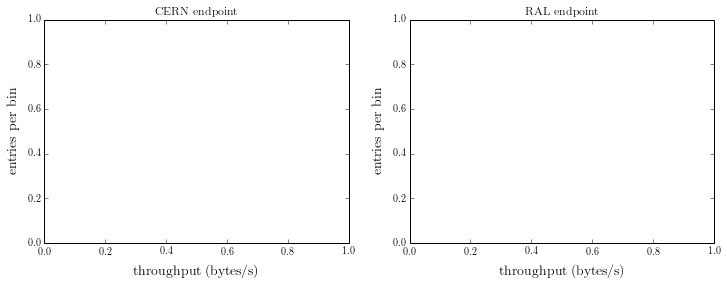

In [37]:
# Basic visual formatting
# TODO = CHANGE TITLES TO INDICATE CUTS!
cax, rax = twoHistos('throughput (bytes/s)')

print cdf2.fsize/cdf2.ttime

# First look at througput, using only records with time>0 and more than 2GB
ch = cax.hist((cdf2.fsize/cdf2.ttime),log=True)
rh = rax.hist((rdf2.fsize/rdf2.ttime),log=True)
plt.tight_layout()